<a href="https://colab.research.google.com/github/redswimmer/valorant-match-analysis/blob/main/Valorant_Match_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Valorant Player Performance Analysis

I noticed there was a large amount of JSON returned from each Valorant match on Tracker.gg and was curious what player analytics I could glean from the data.  I break down the various data types returned and specifically focus on player performance including:

- Round-by-round player performance
- How loadouts affect player performance
- Analyze Side Preference by looking at performance metrics for players when they are attackers or defenders
- Round win predictions using random forest
- Selecting the "best features" for round predictions

Match data is based on a single match from [FNATIC Boaster Tracker Profile](https://tracker.gg/valorant/profile/riot/FNATIC%20Boaster%231010/overview)

**NOTE: This is for educational purposes only and is not in any way affiliated with Riot Games, Tracker.gg or FNATIC.**

## Imports

In [672]:
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

## Load Match Data

Load single match data from the JSON file.

In [673]:
# Specify the path to JSON file
file_path = 'match.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
    match_data = json.load(file)

### Examine record types

Check the different record types returned in the JSON.

In [674]:
# Extract the 'type' field from each segment to find unique types
unique_segment_types = set(segment['type'] for segment in match_data['data']['segments'])

unique_segment_types

{'player-loadout',
 'player-round',
 'player-round-damage',
 'player-round-kills',
 'player-summary',
 'round-summary',
 'team-summary'}

## Parsing Data

In [675]:
# Collection of dataframes for easy access later
dataframe_collection = {}

### Match Summary

Examine the data returned on the match summary.

In [676]:
# Extract the required fields from the JSON data
match_id = match_data['data']['attributes']['id']
mode_name = match_data['data']['metadata']['modeName']
duration = match_data['data']['metadata']['duration']
date_started = match_data['data']['metadata']['dateStarted']
rounds = match_data['data']['metadata']['rounds']
season_id = match_data['data']['metadata']['seasonId']
map = match_data['data']['metadata']['map']
map_name = match_data['data']['metadata']['mapName']

# Create a DataFrame to hold the match summary
match_summary_df = pd.DataFrame({
    'Match_ID': [match_id],
    'Mode_Name': [mode_name],
    'Duration': [duration],
    'Date_Started': [date_started],
    'Rounds': [rounds],
    'Season_Id': [season_id],
    'Map_Id': [map],
    'Map_Name': [map_name],
})

dataframe_collection['match_summary'] = match_summary_df
match_summary_df.head()

,Match_ID,Mode_Name,Duration,Date_Started,Rounds,Season_Id,Map_Id,Map_Name
0,f1b1095d-7fc4-4e17-8fa2-5637650374fa,Competitive,1893354,2023-10-03T13:56:53.093+00:00,20,03dfd004-45d4-ebfd-ab0a-948ce780dac4,2fe4ed3a-450a-948b-6d6b-e89a78e680a9,Lotus


### Team Summary

Examine the data returned on each team summary.

In [677]:
# Filter out the segments where type is "team-summary"
team_summary_segments = [segment for segment in match_data['data']['segments'] if segment['type'] == 'team-summary']

# Extract the required fields from 'attributes', 'metadata', and 'stats'
attributes_data_team = pd.json_normalize([segment['attributes'] for segment in team_summary_segments])[['teamId']]
metadata_data_team = pd.json_normalize([segment['metadata'] for segment in team_summary_segments])[['name', 'hasWon']]

# Extract fields ending in '.value' from 'stats'
stats_data_team = pd.json_normalize([segment['stats'] for segment in team_summary_segments])
stats_data_team = stats_data_team[[col for col in stats_data_team.columns if col.endswith('.value')]]

# Rename columns to remove the '.value' suffix
stats_data_team_renamed = stats_data_team.rename(columns={col: col.replace('.value', '') for col in stats_data_team.columns})

# Concatenate the extracted data to form the streamlined team summary DataFrame
team_summary_df = pd.concat([attributes_data_team, metadata_data_team, stats_data_team_renamed], axis=1)

dataframe_collection['team_summary'] = team_summary_df
team_summary_df.head()

,teamId,name,hasWon,roundsWon,roundsLost,score,kills,deaths,assists,damage
0,Red,Red,True,13,7,21931,81,66,33,14584
1,Blue,Blue,False,7,13,18904,66,81,17,12365


### Player Summary

Examine the data returned on each player summary.

In [678]:
# Filter out the segments where type is "player-summary"
player_summary_segments = [segment for segment in match_data['data']['segments'] if segment['type'] == 'player-summary']

# Extract the required fields from 'attributes' and 'metadata'
attributes_data = pd.json_normalize([segment['attributes'] for segment in player_summary_segments])[['platformUserIdentifier']]
metadata_data = pd.json_normalize([segment['metadata'] for segment in player_summary_segments])[['teamId', 'agentKey', 'agentName']]

# Extract fields ending in '.value' from 'stats'
stats_data = pd.json_normalize([segment['stats'] for segment in player_summary_segments])
stats_data = stats_data[[col for col in stats_data.columns if col.endswith('.value')]]

# Convert list of stats to a comma-separated string
trn_performance_score_stats_str = [",".join(segment['stats'].get('trnPerformanceScore', {}).get('metadata', {}).get('stats', [])) for segment in player_summary_segments]

# Create a DataFrame with the stats string
trn_performance_score_stats_df_str = pd.DataFrame({'trnPerformanceStats': trn_performance_score_stats_str})

# Rename columns to remove the '.value' suffix
stats_data_renamed = stats_data.rename(columns={col: col.replace('.value', '') for col in stats_data.columns})

# Concatenate the extracted data to form the updated player summary DataFrame
player_summary_df = pd.concat([attributes_data, metadata_data, stats_data_renamed, trn_performance_score_stats_df_str], axis=1)

dataframe_collection['player_summary'] = player_summary_df
player_summary_df.head()

,platformUserIdentifier,teamId,agentKey,agentName,rank,currRank,score,scorePerRound,killsPerRound,kills,...,esr,firstKillsPerRound,firstDeathsPerRound,econRating,hsAccuracy,kast,clutches,roundsWinPct,trnPerformanceScore,trnPerformanceStats
0,Z10 kaajak#4747,Blue,f94c3b30-42be-e959-889c-5aa313dba261,Raze,Radiant,244,5937,296.85,1.00,20,...,100.000000,0.15,0.00,67,25.000000,70.0,1,35.0,635,"roundsWinPct,kAST,scorePerRound,damageDeltaPer..."
1,Z10 kenobi#77777,Blue,6f2a04ca-43e0-be17-7f36-b3908627744d,Skye,Radiant,423,3311,165.55,0.55,11,...,55.555556,0.25,0.20,38,50.000000,65.0,0,35.0,52,"roundsWinPct,kAST,scorePerRound,damageDeltaPer..."
2,KPI pupsik#gang,Red,1e58de9c-4950-5125-93e9-a0aee9f98746,Killjoy,Immortal 3,358,4720,236.00,0.75,15,...,40.000000,0.10,0.15,82,31.034483,85.0,1,65.0,928,"roundsWinPct,kAST,scorePerRound,damageDeltaPer..."
3,FNATIC Boaster#1010,Red,f94c3b30-42be-e959-889c-5aa313dba261,Raze,Radiant,Radiant,4880,244.00,0.90,18,...,50.000000,0.10,0.10,51,9.375000,70.0,0,65.0,720,"roundsWinPct,kAST,scorePerRound,damageDeltaPer..."
4,Liquid Mistic#SUMN,Red,9f0d8ba9-4140-b941-57d3-a7ad57c6b417,Brimstone,Immortal 3,Immortal 2,4229,211.45,0.75,15,...,25.000000,0.05,0.15,51,50.000000,90.0,0,65.0,704,"roundsWinPct,kAST,scorePerRound,damageDeltaPer..."


### Player Loadouts

Examine the data returned on each player loadout summary.

In [679]:
# Filter out the segments where type is "player-loadout"
player_loadout_segments = [segment for segment in match_data['data']['segments'] if segment['type'] == 'player-loadout']

# Extract the required fields from 'attributes'
attributes_data_player_loadout = pd.json_normalize([segment['attributes'] for segment in player_loadout_segments])[['loadout', 'platformUserIdentifier']]

# Extract fields ending in '.value' from 'stats'
stats_data_player_loadout = pd.json_normalize([segment['stats'] for segment in player_loadout_segments])
stats_data_player_loadout = stats_data_player_loadout[[col for col in stats_data_player_loadout.columns if col.endswith('.value')]]

# Rename columns to remove the '.value' suffix
stats_data_player_loadout_renamed = stats_data_player_loadout.rename(columns={col: col.replace('.value', '') for col in stats_data_player_loadout.columns})

# Concatenate the extracted data to form the player-loadout DataFrame
player_loadout_df = pd.concat([attributes_data_player_loadout, stats_data_player_loadout_renamed], axis=1)

dataframe_collection['player_loadout'] = player_loadout_df
player_loadout_df.head()

,loadout,platformUserIdentifier,kills,deaths,kDRatio,assists,roundsPlayed,roundsWon,roundsLost,roundsWinPct,...,survived,firstBloods,firstDeaths,esr,kAST,kasted,damagePerRound,scorePerRound,damageDelta,damageDeltaPerRound
0,pistol,Z10 kaajak#4747,1,2,0.500000,1,2,0,2,0.0,...,0,0,0,0.0,100.0,2,95.000,128.500,-107,-53.500
1,eco,Z10 kaajak#4747,3,1,3.000000,0,2,1,1,50.0,...,1,0,0,0.0,50.0,1,233.500,401.000,346,173.000
2,semi,Z10 kaajak#4747,8,7,1.142857,3,8,3,5,37.5,...,1,3,0,100.0,75.0,6,202.500,319.625,289,36.125
3,full,Z10 kaajak#4747,8,7,1.142857,1,8,3,5,37.5,...,1,0,0,0.0,62.5,5,199.375,290.125,262,32.750
4,pistol,Z10 kenobi#77777,1,2,0.500000,1,2,0,2,0.0,...,0,0,0,0.0,100.0,2,57.500,125.000,-160,-80.000


### Round Summary

Examine the data returned on each round summary.

In [680]:
# Filter out segments where the type is "round-summary"
round_summary_segments = [segment for segment in match_data['data']['segments'] if segment['type'] == 'round-summary']

# Extract all fields from 'attributes'
attributes_data_round = pd.json_normalize([segment['attributes'] for segment in round_summary_segments])

# Flatten the metadata, including plant and defuse details
metadata_data_round_flattened = pd.json_normalize([segment['metadata'] for segment in round_summary_segments])

# Function to flatten specific sections like 'plant' or 'defuse' into a single row with multiple columns for each player
def flatten_section(section_data, section_name):
    flattened = {}
    if isinstance(section_data, list):
        for i, loc in enumerate(section_data):
            if loc:
                for key, value in loc.items():
                    if isinstance(value, dict):
                        for sub_key, sub_value in value.items():
                            flattened[f'{section_name}.player{i+1}.{key}_{sub_key}'] = sub_value
                    else:
                        flattened[f'{section_name}.player{i+1}.{key}'] = value
    return flattened

# Apply the function to flatten 'plant.playerLocations' and 'defuse.playerLocations' into individual columns
plant_locations_flattened = pd.DataFrame(metadata_data_round_flattened['plant.playerLocations'].apply(lambda x: flatten_section(x, 'plant') if x else {}).tolist())
defuse_locations_flattened = pd.DataFrame(metadata_data_round_flattened['defuse.playerLocations'].apply(lambda x: flatten_section(x, 'defuse') if x else {}).tolist())

# Extract fields ending in '.value' from 'stats'
stats_data_round = pd.json_normalize([segment['stats'] for segment in round_summary_segments])
stats_data_round_values = stats_data_round[[col for col in stats_data_round.columns if col.endswith('.value')]]

# Rename columns to remove the '.value' suffix
stats_data_round_values_renamed = stats_data_round_values.rename(columns={col: col.replace('.value', '') for col in stats_data_round_values.columns})

# Concatenate all the DataFrames to create the final round_summary DataFrame
round_summary_df = pd.concat([
    attributes_data_round,
    metadata_data_round_flattened.drop(['plant.playerLocations', 'defuse.playerLocations'], axis=1),
    plant_locations_flattened,
    defuse_locations_flattened,
    stats_data_round_values_renamed
], axis=1)

dataframe_collection['round_summary'] = round_summary_df
round_summary_df.head()

,round,defuse,exploded,plant.platformUserIdentifier,plant.location.x,plant.location.y,plant.roundTime,plant.site,plant,defuse.platformUserIdentifier,...,defuse.player3.platformUserIdentifier,defuse.player3.location_x,defuse.player3.location_y,defuse.player3.viewRadians,defuse.player4.platformUserIdentifier,defuse.player4.location_x,defuse.player4.location_y,defuse.player4.viewRadians,roundResult,winningTeam
0,1,NaN,None,Dawn#92i,7519.0,5236.0,21344.0,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Elimination,Red
1,2,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Elimination,Blue
2,3,NaN,None,Dawn#92i,7554.0,5888.0,25958.0,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Elimination,Red
3,4,NaN,None,Dawn#92i,7731.0,5992.0,67762.0,A,NaN,Eung#meow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Defuse,Blue
4,5,NaN,None,Liquid Mistic#SUMN,7693.0,5992.0,58582.0,A,NaN,Danillize#EUW,...,Eung#meow,7334.0,5871.0,0.615318,Danillize#EUW,7563.0,5973.0,4.051819,Defuse,Blue


### Player Round By Round

Examine the data returned on each player's round summary.  This is the bulk of the data we'll be focusing on.

In [681]:
# Filter out the segments where type is "player-round"
player_round_segments = [segment for segment in match_data['data']['segments'] if segment['type'] == 'player-round']

# Extract the required fields from 'attributes'
attributes_data_player_round = pd.json_normalize([segment['attributes'] for segment in player_round_segments])[['round', 'platformUserIdentifier']]

# Extract the required fields from 'metadata'
metadata_data_player_round = pd.json_normalize([segment['metadata'] for segment in player_round_segments])[['teamId', 'teamSide', 'agentKey', 'hasWon']]

# Extract fields ending in '.value' from 'stats'
stats_data_player_round = pd.json_normalize([segment['stats'] for segment in player_round_segments])
stats_data_player_round = stats_data_player_round[[col for col in stats_data_player_round.columns if col.endswith('.value')]]

# Rename columns to remove the '.value' suffix
stats_data_player_round_renamed = stats_data_player_round.rename(columns={col: col.replace('.value', '') for col in stats_data_player_round.columns})

# Concatenate the extracted data to form the player-round DataFrame
player_round_df = pd.concat([attributes_data_player_round, metadata_data_player_round, stats_data_player_round_renamed], axis=1)

# Add Agent Name column
unique_agents = player_summary_df[['platformUserIdentifier', 'agentName']].drop_duplicates()

# Merge the player_round_df with the unique_agents to get the agentName
player_round_df = player_round_df.merge(unique_agents, on='platformUserIdentifier', how='left')

# Now player_round_df will have an additional column 'agentName' from player_summary_df
dataframe_collection['player_round'] = player_round_df
player_round_df.head()

,round,platformUserIdentifier,teamId,teamSide,agentKey,hasWon,score,kills,deaths,kdRatio,assists,damage,loadoutValue,remainingCredits,spentCredits,agentName
0,1,Dawn#92i,Red,attacker,6f2a04ca-43e0-be17-7f36-b3908627744d,True,140,1,0,1.0,0,105,1000,50,750,Skye
1,1,Liquid Mistic#SUMN,Red,attacker,9f0d8ba9-4140-b941-57d3-a7ad57c6b417,True,585,2,1,2.0,0,270,900,0,800,Brimstone
2,1,Z10 kaajak#4747,Blue,defender,f94c3b30-42be-e959-889c-5aa313dba261,False,202,1,1,1.0,0,135,700,100,700,Raze
3,1,Z10 kenobi#77777,Blue,defender,6f2a04ca-43e0-be17-7f36-b3908627744d,False,195,1,1,1.0,1,60,1000,50,750,Skye
4,1,FNATIC Boaster#1010,Red,attacker,f94c3b30-42be-e959-889c-5aa313dba261,True,180,1,1,1.0,0,86,800,0,800,Raze


### Player Round Damage

Examine the data returned on each player's round damage summary.

In [682]:
# Filter out the segments where type is "player-round-damage"
player_round_damage_segments = [segment for segment in match_data['data']['segments'] if segment['type'] == 'player-round-damage']

# Extract the required fields from 'attributes'
attributes_data_player_round_damage = pd.json_normalize([segment['attributes'] for segment in player_round_damage_segments])[['round', 'platformUserIdentifier', 'opponentPlatformUserIdentifier']]

# Extract fields ending in '.value' from 'stats'
stats_data_player_round_damage = pd.json_normalize([segment['stats'] for segment in player_round_damage_segments])
stats_data_player_round_damage = stats_data_player_round_damage[[col for col in stats_data_player_round_damage.columns if col.endswith('.value')]]

# Rename columns to remove the '.value' suffix
stats_data_player_round_damage_renamed = stats_data_player_round_damage.rename(columns={col: col.replace('.value', '') for col in stats_data_player_round_damage.columns})

# Concatenate the extracted data to form the player-round-damage DataFrame
player_round_damage_df = pd.concat([attributes_data_player_round_damage, stats_data_player_round_damage_renamed], axis=1)

dataframe_collection['player_round_damage'] = player_round_damage_df
player_round_damage_df.head()

,round,platformUserIdentifier,opponentPlatformUserIdentifier,damage,legshots,bodyshots,headshots
0,1,Dawn#92i,Danillize#EUW,105,0,0,1
1,1,Liquid Mistic#SUMN,Eung#meow,105,0,0,1
2,1,Liquid Mistic#SUMN,kwert#kwert,135,0,1,1
3,1,Liquid Mistic#SUMN,Z10 kaajak#4747,30,0,1,0
4,1,Z10 kaajak#4747,Liquid Mistic#SUMN,105,0,0,1


### Player Round Kills

Examine the data returned on each player's round kills summary.

In [683]:
# Function to flatten player locations into a single row with multiple columns for each player
def flatten_player_locations(player_locations, prefix=''):
    flattened = {}
    if isinstance(player_locations, list):
        for i, loc in enumerate(player_locations):
            if loc:
                for key, value in loc.items():
                    if isinstance(value, dict):
                        for sub_key, sub_value in value.items():
                            flattened[f'{prefix}player{i+1}.{key}_{sub_key}'] = sub_value
                    else:
                        flattened[f'{prefix}player{i+1}.{key}'] = value
    return flattened

# Filter out the segments where type is "player-round-kills"
player_round_kills_segments = [segment for segment in match_data['data']['segments'] if segment['type'] == 'player-round-kills']

# Extract the required fields from 'attributes'
attributes_data_player_round_kills = pd.json_normalize([segment['attributes'] for segment in player_round_kills_segments])[['round', 'platformUserIdentifier', 'opponentPlatformUserIdentifier']]

# Extract the non-nested fields from 'metadata'
metadata_data_player_round_kills_non_nested = pd.json_normalize([segment['metadata'] for segment in player_round_kills_segments])[['playerLocations', 'assistants', 'weaponName', 'weaponCategory', 'gameTime', 'roundTime']]

# Extract the nested fields 'opponentLocation' and 'finishingDamage' from 'metadata'
metadata_data_player_round_kills_nested = pd.json_normalize([segment['metadata'] for segment in player_round_kills_segments], sep='_')[['opponentLocation_x', 'opponentLocation_y', 'finishingDamage_damageType', 'finishingDamage_damageItem', 'finishingDamage_isSecondaryFireMode']]

# Apply the function to flatten 'playerLocations' into individual columns
player_locations_flattened_kills = pd.DataFrame([flatten_player_locations(segment['metadata'].get('playerLocations'), 'kills_') for segment in player_round_kills_segments])

# Extract fields ending in '.value' from 'stats'
stats_data_player_round_kills = pd.json_normalize([segment['stats'] for segment in player_round_kills_segments])
stats_data_player_round_kills_values = stats_data_player_round_kills[[col for col in stats_data_player_round_kills.columns if col.endswith('.value')]]

# Rename columns to remove the '.value' suffix
stats_data_player_round_kills_renamed = stats_data_player_round_kills_values.rename(columns={col: col.replace('.value', '') for col in stats_data_player_round_kills_values.columns})

# Concatenate the extracted data to form the player-round-kills DataFrame, including the flattened playerLocations and assistants
player_round_kills_df = pd.concat([
    attributes_data_player_round_kills,
    metadata_data_player_round_kills_non_nested.drop(['playerLocations', 'assistants'], axis=1),
    metadata_data_player_round_kills_nested,
    player_locations_flattened_kills,
    stats_data_player_round_kills_renamed
], axis=1)

dataframe_collection['player_round_kills'] = player_round_kills_df
player_round_kills_df.head()

,round,platformUserIdentifier,opponentPlatformUserIdentifier,weaponName,weaponCategory,gameTime,roundTime,opponentLocation_x,opponentLocation_y,finishingDamage_damageType,...,kills_player7.viewRadians,kills_player8.platformUserIdentifier,kills_player8.location_x,kills_player8.location_y,kills_player8.viewRadians,kills_player9.platformUserIdentifier,kills_player9.location_x,kills_player9.location_y,kills_player9.viewRadians,damage
0,1,Dawn#92i,Danillize#EUW,Ghost,Sidearms,112849,57822,7544,5111,Weapon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135
1,1,Liquid Mistic#SUMN,Eung#meow,Ghost,Sidearms,62318,7291,6445,899,Weapon,...,1.192866,KPI pupsik#gang,3374.0,2589.0,1.051868,kwert#kwert,5764.0,1864.0,5.203362,105
2,1,Liquid Mistic#SUMN,kwert#kwert,Ghost,Sidearms,63542,8515,5742,1740,Weapon,...,1.132655,KPI pupsik#gang,3549.0,2815.0,0.677923,NaN,NaN,NaN,NaN,135
3,1,Z10 kaajak#4747,Liquid Mistic#SUMN,Ghost,Sidearms,64084,9057,5993,-451,Weapon,...,0.677922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183
4,1,Z10 kenobi#77777,FNATIC Boaster#1010,Ghost,Sidearms,67415,12388,6345,1230,Weapon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145


### Export to CSV

Export each dataframe to a CSV in the exports folder for easier reading.  I used this to cross-check my results and interface with OpenAI for analysis.

In [684]:
# for name, df in dataframe_collection.items():
#     df.to_csv(f'exports/{name}.csv', index=False)

## Analysis

### By Player

Calculate Player Performance based on K/D ratio, assists, and damage

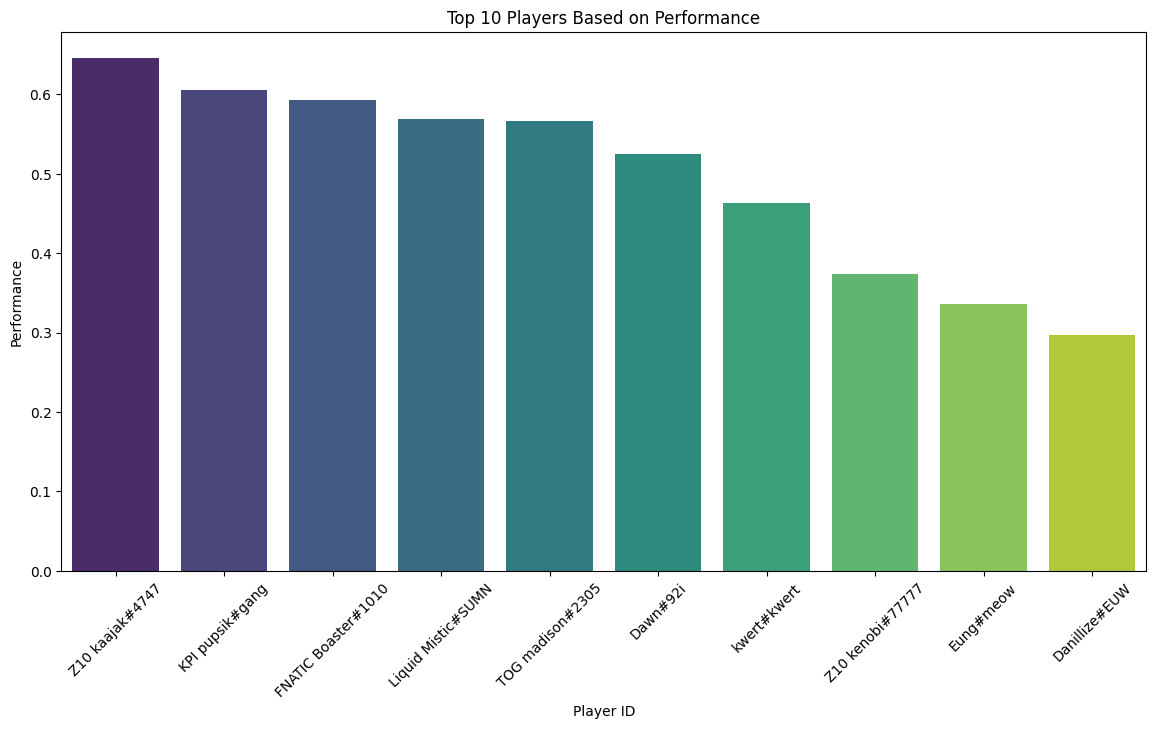

In [685]:
# We'll normalize each of these metrics to have a common scale (0-1) and sum them up for an performance score
def calculate_player_performance(df):
    df['kdRatio_norm'] = df['kdRatio'] / df['kdRatio'].max()
    df['assists_norm'] = df['assists'] / df['assists'].max()
    df['damage_norm'] = df['damage'] / df['damage'].max()
    df['performance'] = df['kdRatio_norm'] + df['assists_norm'] + df['damage_norm']
    return df

player_round_df = calculate_player_performance(player_round_df)

# Plot the top 10 players based on Performance
top_players = player_round_df.groupby('platformUserIdentifier')['performance'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 7))
sns.barplot(x=top_players.index, y=top_players.values, palette='viridis')
plt.title('Top 10 Players Based on Performance')
plt.xlabel('Player ID')
plt.ylabel('Performance')
plt.xticks(rotation=45)
plt.show()

The bar chart above shows the top 10 players based on an 'Performance' score. This score is a simple sum of the normalized values of K/D ratio, assists, and damage dealt by each player.

Here's how the performance is calculated:

1. Normalize each metric (K/D ratio, assists, and damage) by dividing it by the maximum value in the dataset for that metric.
2. Sum these normalized metrics to get an 'Performance' score for each player.

Analyze Economic Management by looking at how efficiently players are managing their in-game credits.  We will calculate an 'Economic Efficiency' metric based on credits spent and remaining credits

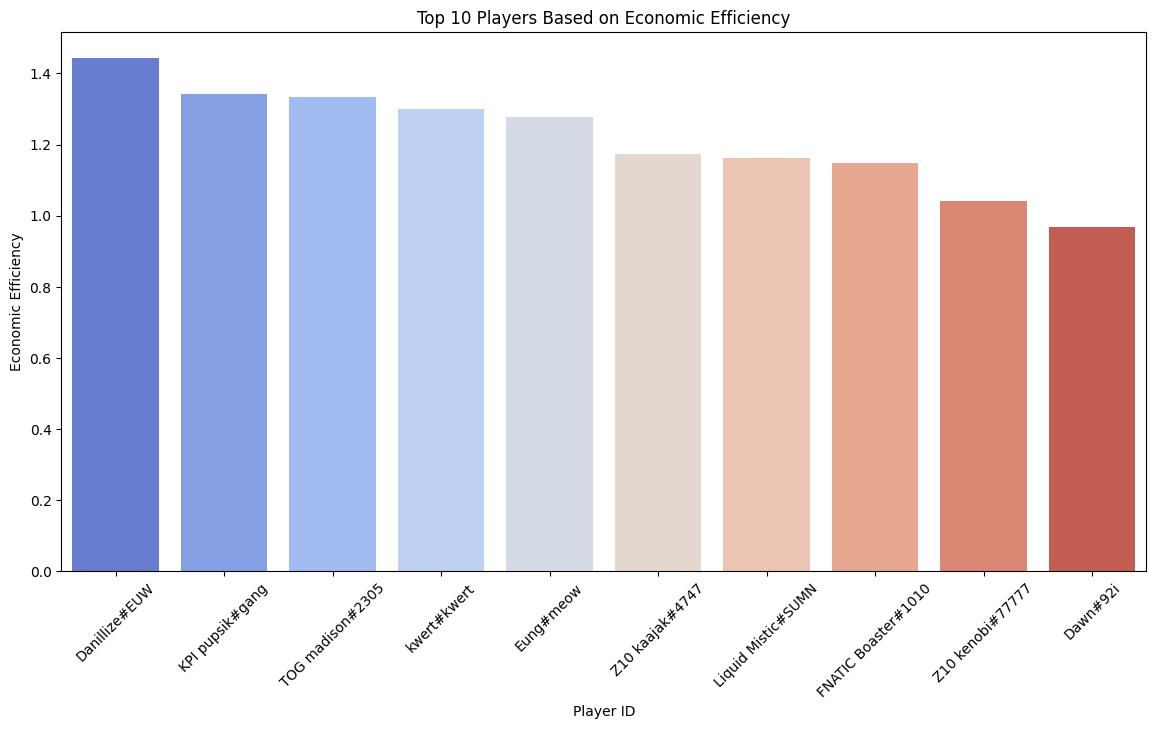

In [686]:
# Calculate Economic Efficiency and Skip the rows where loadoutValue is zero before the division
player_round_df['economic_efficiency'] = np.where(player_round_df['loadoutValue'] == 0, np.nan, (player_round_df['spentCredits'] + player_round_df['remainingCredits']) / player_round_df['loadoutValue'])

# Plot the top 10 players based on Economic Efficiency
top_economic_players = player_round_df.groupby('platformUserIdentifier')['economic_efficiency'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 7))
sns.barplot(x=top_economic_players.index, y=top_economic_players.values, palette='coolwarm')
plt.title('Top 10 Players Based on Economic Efficiency')
plt.xlabel('Player ID')
plt.ylabel('Economic Efficiency')
plt.xticks(rotation=45)
plt.show()

The bar chart above showcases the top 10 players based on an 'Economic Efficiency' score. This score is calculated as the sum of credits spent and remaining credits, divided by the loadout value. A higher value indicates better economic management, which implies that the player is either spending wisely or accumulating more credits without compromising effectiveness.

This kind of insight is valuable for a coach who wants to manage the team's in-game economy better. Knowing who the economic anchors are could help in strategizing credit distribution and planning for crucial rounds.

Analyze Side Preference by looking at performance metrics for players when they are attackers or defenders

<Figure size 1400x700 with 0 Axes>

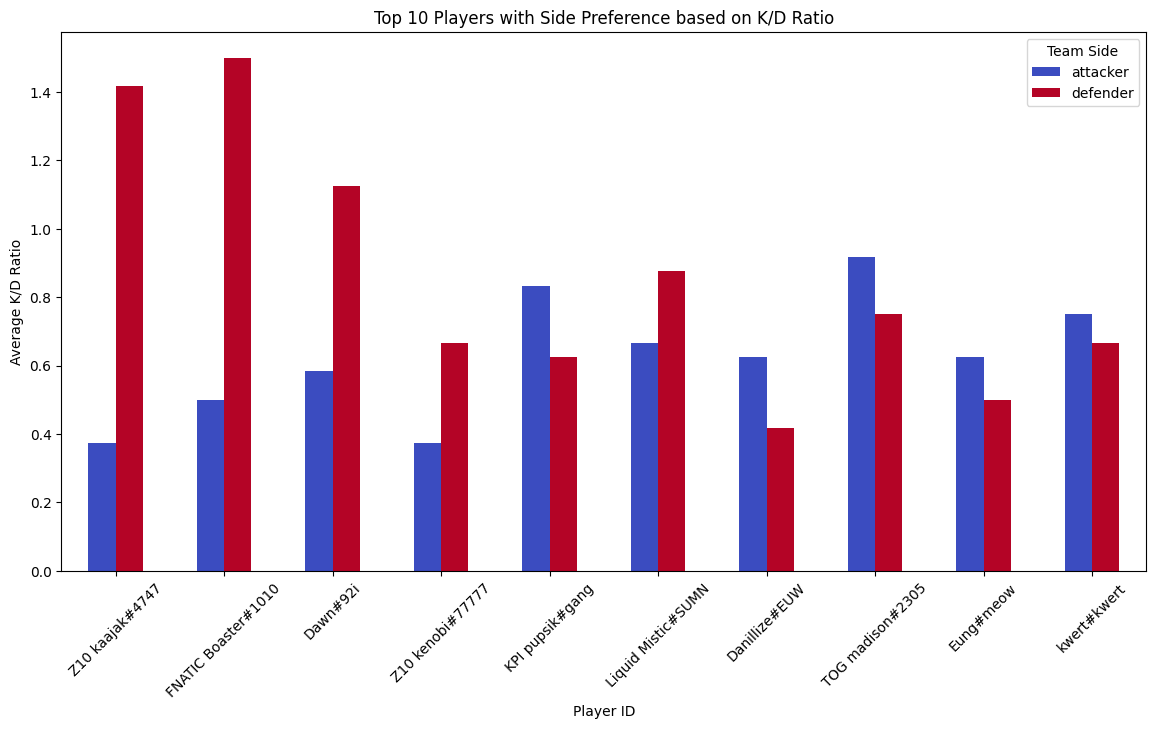

In [687]:
# Calculate average K/D ratio for each player when they are an attacker or a defender
side_preference_df = player_round_df.groupby(['platformUserIdentifier', 'teamSide'])['kdRatio'].mean().reset_index()
side_preference_df = side_preference_df.pivot(index='platformUserIdentifier', columns='teamSide', values='kdRatio').fillna(0)

# Plotting the top 10 players who have a significant difference in K/D ratio when they are attackers or defenders
side_preference_df['difference'] = abs(side_preference_df['attacker'] - side_preference_df['defender'])
top_side_preference_players = side_preference_df.sort_values('difference', ascending=False).head(10)

# Plot
plt.figure(figsize=(14, 7))
top_side_preference_players[['attacker', 'defender']].plot(kind='bar', figsize=(14, 7), colormap='coolwarm')
plt.title('Top 10 Players with Side Preference based on K/D Ratio')
plt.xlabel('Player ID')
plt.ylabel('Average K/D Ratio')
plt.xticks(ticks=range(len(top_side_preference_players)), labels=top_side_preference_players.index, rotation=45)
plt.legend(title='Team Side')
plt.show()

The bar chart above illustrates the top 10 players who exhibit a significant difference in their average K/D ratio when playing as attackers versus defenders. Each player's average K/D ratio for both sides is displayed, allowing us to observe which side they seem to prefer or excel at.

Understanding these preferences can be instrumental for a coach. For example, if a player has a notably higher K/D ratio as an attacker, it might be beneficial to position them as such in crucial rounds.

### By Loadout

Analyze Loadout Efficiency by player, breaking down how different types of loadouts affect individual player performance

In [688]:
# Calculate average kills, deaths, and assists for each player and type of loadout
loadout_efficiency_by_player_df = player_loadout_df.groupby(['platformUserIdentifier', 'loadout']).agg({
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean'
}).reset_index()

# Reorder the DataFrame based on the desired loadout order: 'full', 'semi', 'eco', 'pistol'
loadout_order = ['full', 'semi', 'eco', 'pistol']
loadout_efficiency_by_player_df['loadout'] = pd.Categorical(loadout_efficiency_by_player_df['loadout'], categories=loadout_order, ordered=True)
loadout_efficiency_by_player_df = loadout_efficiency_by_player_df.sort_values(['platformUserIdentifier', 'loadout'])

# Plotting Loadout Efficiency by Player for the top 10 players based on average kills
top_players = loadout_efficiency_by_player_df.groupby('platformUserIdentifier')['kills'].mean().sort_values(ascending=False).head(10).index
top_players_loadout_efficiency = loadout_efficiency_by_player_df[loadout_efficiency_by_player_df['platformUserIdentifier'].isin(top_players)]

# Show a sample of the loadout_efficiency_by_player_df DataFrame
loadout_efficiency_by_player_df.head()

,platformUserIdentifier,loadout,kills,deaths,assists
1,Danillize#EUW,full,1.0,4.0,0.0
3,Danillize#EUW,semi,5.0,6.0,0.0
0,Danillize#EUW,eco,2.0,4.0,1.0
2,Danillize#EUW,pistol,2.0,2.0,0.0
5,Dawn#92i,full,8.0,1.0,0.0


<Figure size 1600x1000 with 0 Axes>

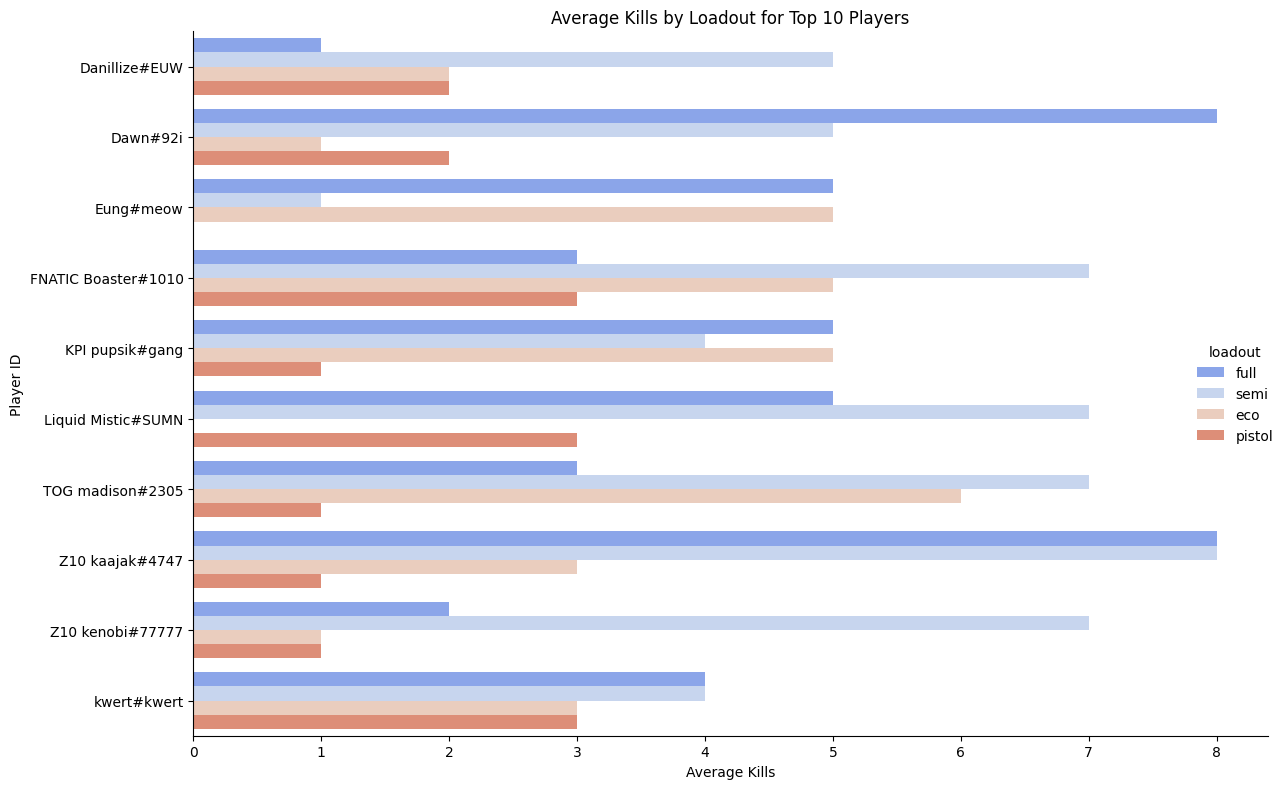

In [689]:
# Average Kills by Loadout for Top 10 Players
plt.figure(figsize=(16, 10))
sns.catplot(x="kills", y="platformUserIdentifier", hue="loadout", data=top_players_loadout_efficiency, kind="bar", height=8, aspect=1.5, palette="coolwarm")
plt.title('Average Kills by Loadout for Top 10 Players')
plt.xlabel('Average Kills')
plt.ylabel('Player ID')
plt.tight_layout()
plt.show()

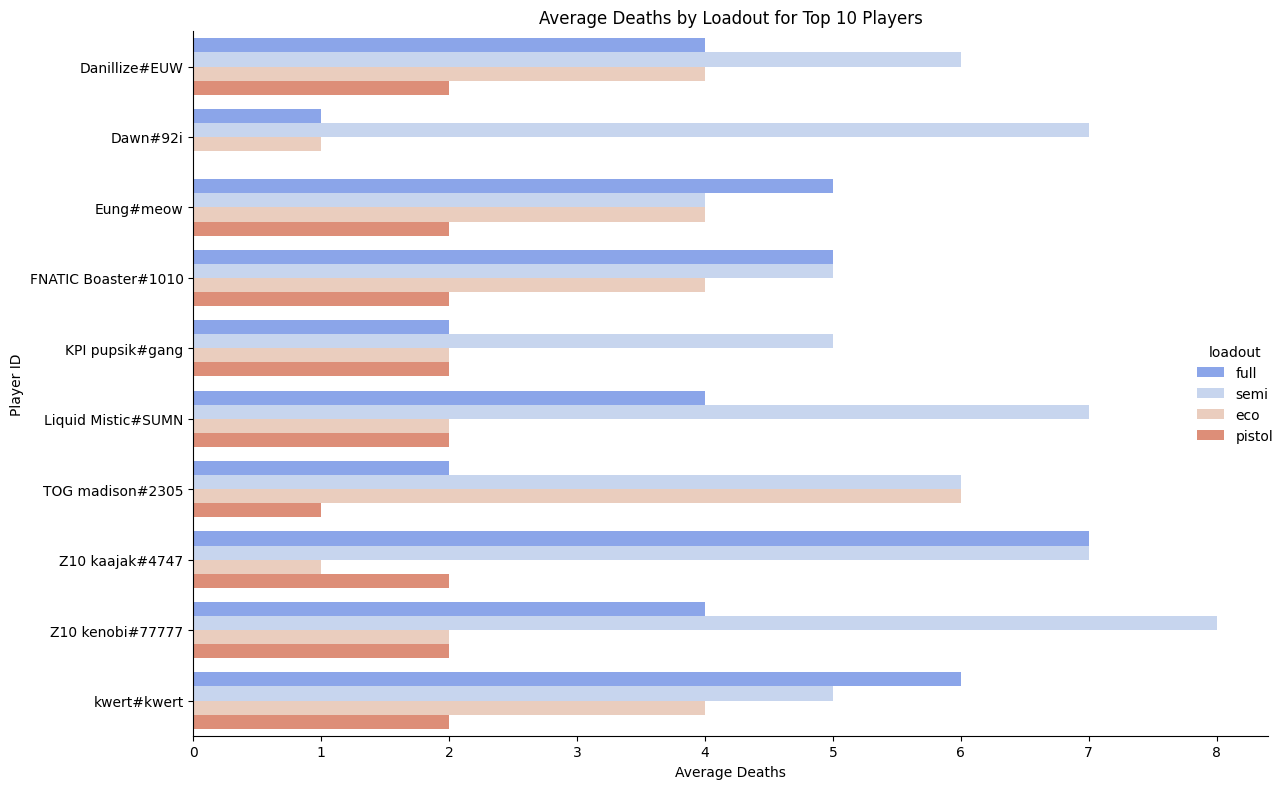

In [690]:
# Average Deaths by Loadout for Top 10 Players
sns.catplot(x="deaths", y="platformUserIdentifier", hue="loadout", data=top_players_loadout_efficiency, kind="bar", height=8, aspect=1.5, palette="coolwarm")
plt.title('Average Deaths by Loadout for Top 10 Players')
plt.xlabel('Average Deaths')
plt.ylabel('Player ID')
plt.tight_layout()
plt.show()

Summarize loadout analysis for all players

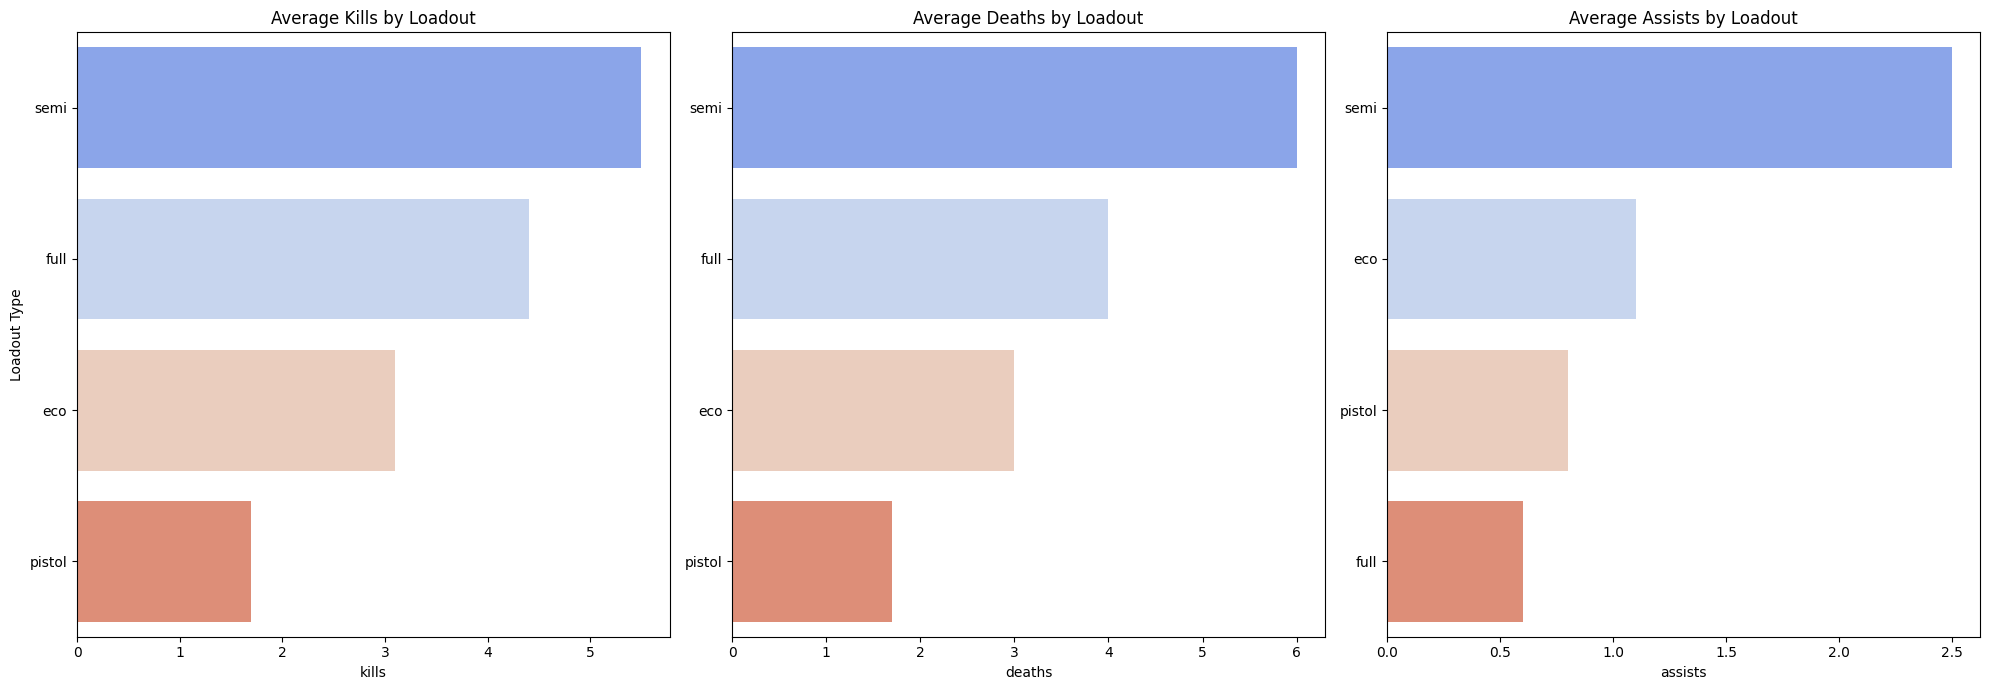

,loadout,kills,deaths,assists
0,eco,3.1,3.0,1.1
1,full,4.4,4.0,0.6
2,pistol,1.7,1.7,0.8
3,semi,5.5,6.0,2.5


In [692]:
# Calculate average kills, deaths, and assists for each type of loadout
loadout_efficiency_df = player_loadout_df.groupby('loadout').agg({
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean'
}).reset_index()

# Plotting Loadout Efficiency
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
sns.barplot(x='kills', y='loadout', data=loadout_efficiency_df.sort_values('kills', ascending=False), ax=axes[0], palette='coolwarm')
sns.barplot(x='deaths', y='loadout', data=loadout_efficiency_df.sort_values('deaths', ascending=False), ax=axes[1], palette='coolwarm')
sns.barplot(x='assists', y='loadout', data=loadout_efficiency_df.sort_values('assists', ascending=False), ax=axes[2], palette='coolwarm')

axes[0].set_title('Average Kills by Loadout')
axes[1].set_title('Average Deaths by Loadout')
axes[2].set_title('Average Assists by Loadout')

for ax in axes:
    ax.set_ylabel('')

axes[0].set_ylabel('Loadout Type')

plt.tight_layout()
plt.show()

# Show the new loadout_efficiency_df DataFrame
loadout_efficiency_df.head()


The set of bar charts above represents the average performance metrics—kills, deaths, and assists—associated with different types of loadouts:

- **Average Kills by Loadout:** The "semi" loadout leads with an average of about 5.5 kills, followed by "full" with approximately 4.4 kills.
- **Average Deaths by Loadout:** Interestingly, the "semi" loadout also has the highest average deaths of about 6.0, suggesting it might be a high-risk, high-reward choice.
- **Average Assists by Loadout:** Again, the "semi" loadout stands out with an average of 2.5 assists.

Analyze Damage Metrics by player, breaking down how different types of loadouts affect individual player performance

In [693]:
# Calculate average 'damagePerRound' and 'damageDeltaPerRound' for each player and type of loadout
damage_metrics_by_player_df = player_loadout_df.groupby(['platformUserIdentifier', 'loadout']).agg({
    'damagePerRound': 'mean',
    'damageDeltaPerRound': 'mean'
}).reset_index()

# Reorder the DataFrame based on the desired loadout order: 'full', 'semi', 'eco', 'pistol'
damage_metrics_by_player_df['loadout'] = pd.Categorical(damage_metrics_by_player_df['loadout'], categories=loadout_order, ordered=True)
damage_metrics_by_player_df = damage_metrics_by_player_df.sort_values(['platformUserIdentifier', 'loadout'])

# Plotting Damage Metrics by Player for the top 10 players based on average 'damagePerRound'
top_players_damage = damage_metrics_by_player_df.groupby('platformUserIdentifier')['damagePerRound'].mean().sort_values(ascending=False).head(10).index
top_players_damage_metrics = damage_metrics_by_player_df[damage_metrics_by_player_df['platformUserIdentifier'].isin(top_players_damage)]

# Show a sample of the damage_metrics_by_player_df DataFrame
damage_metrics_by_player_df.head()


,platformUserIdentifier,loadout,damagePerRound,damageDeltaPerRound
1,Danillize#EUW,full,53.833333,-41.333333
3,Danillize#EUW,semi,149.500000,-64.833333
0,Danillize#EUW,eco,91.333333,-26.166667
2,Danillize#EUW,pistol,152.500000,9.500000
5,Dawn#92i,full,358.500000,263.750000


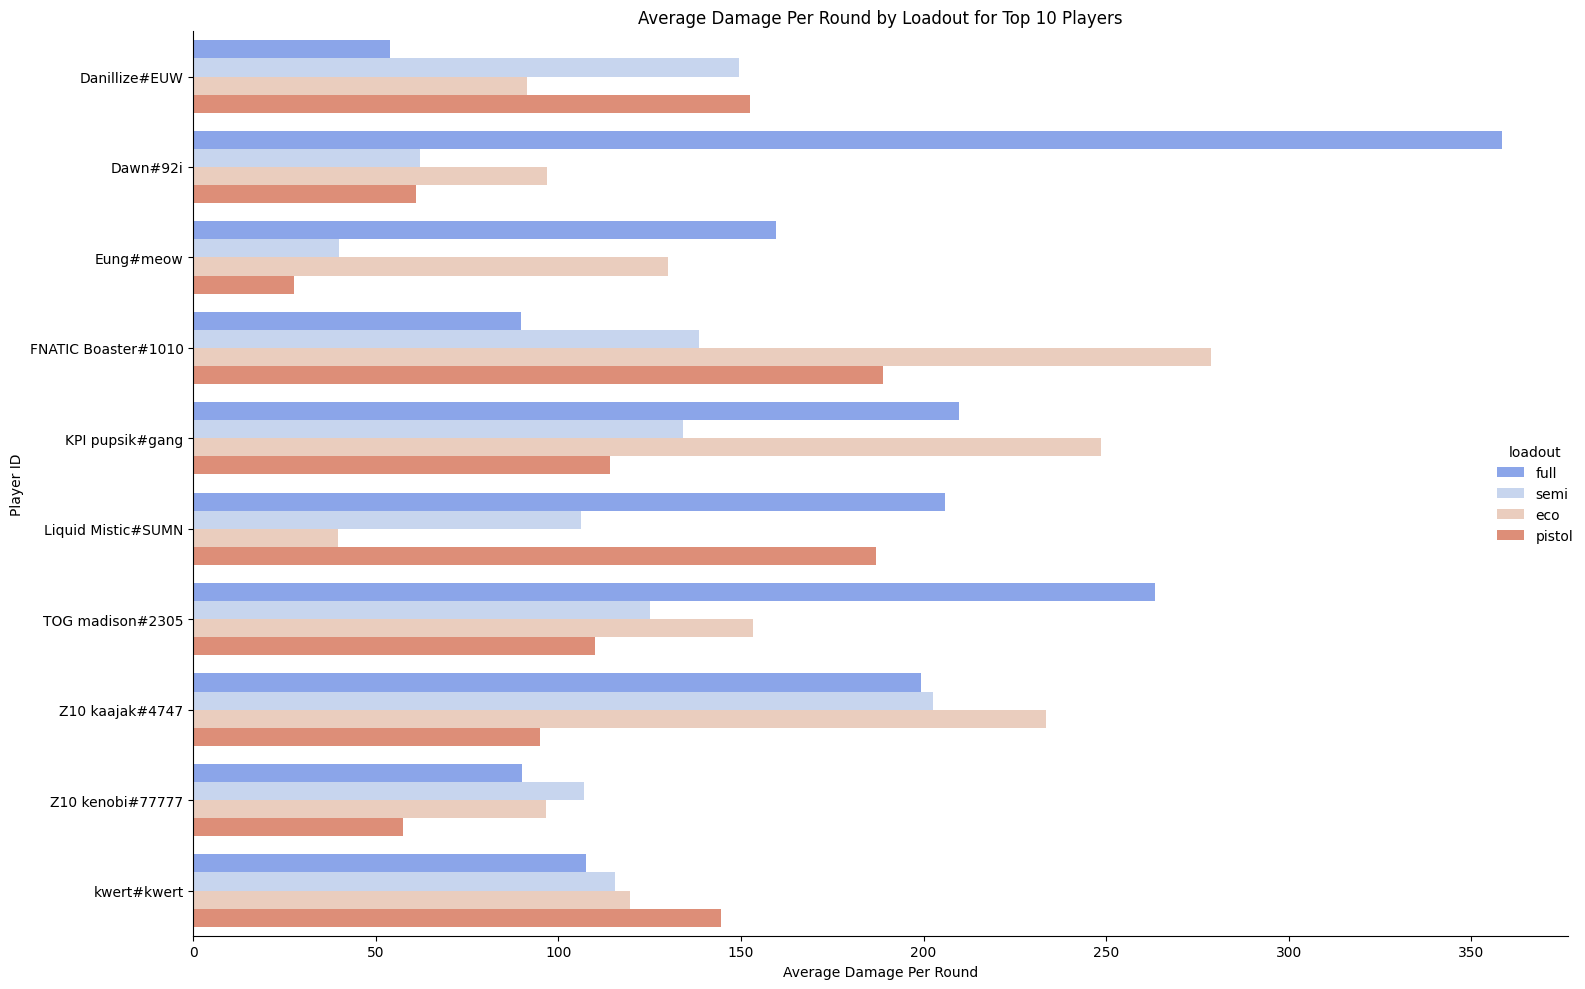

In [694]:
# Average Damage Per Round by Loadout for Top 10 Players
sns.catplot(x="damagePerRound", y="platformUserIdentifier", hue="loadout", data=top_players_damage_metrics, kind="bar", height=10, aspect=1.5, palette="coolwarm")
plt.title('Average Damage Per Round by Loadout for Top 10 Players')
plt.xlabel('Average Damage Per Round')
plt.ylabel('Player ID')
plt.tight_layout()
plt.show()

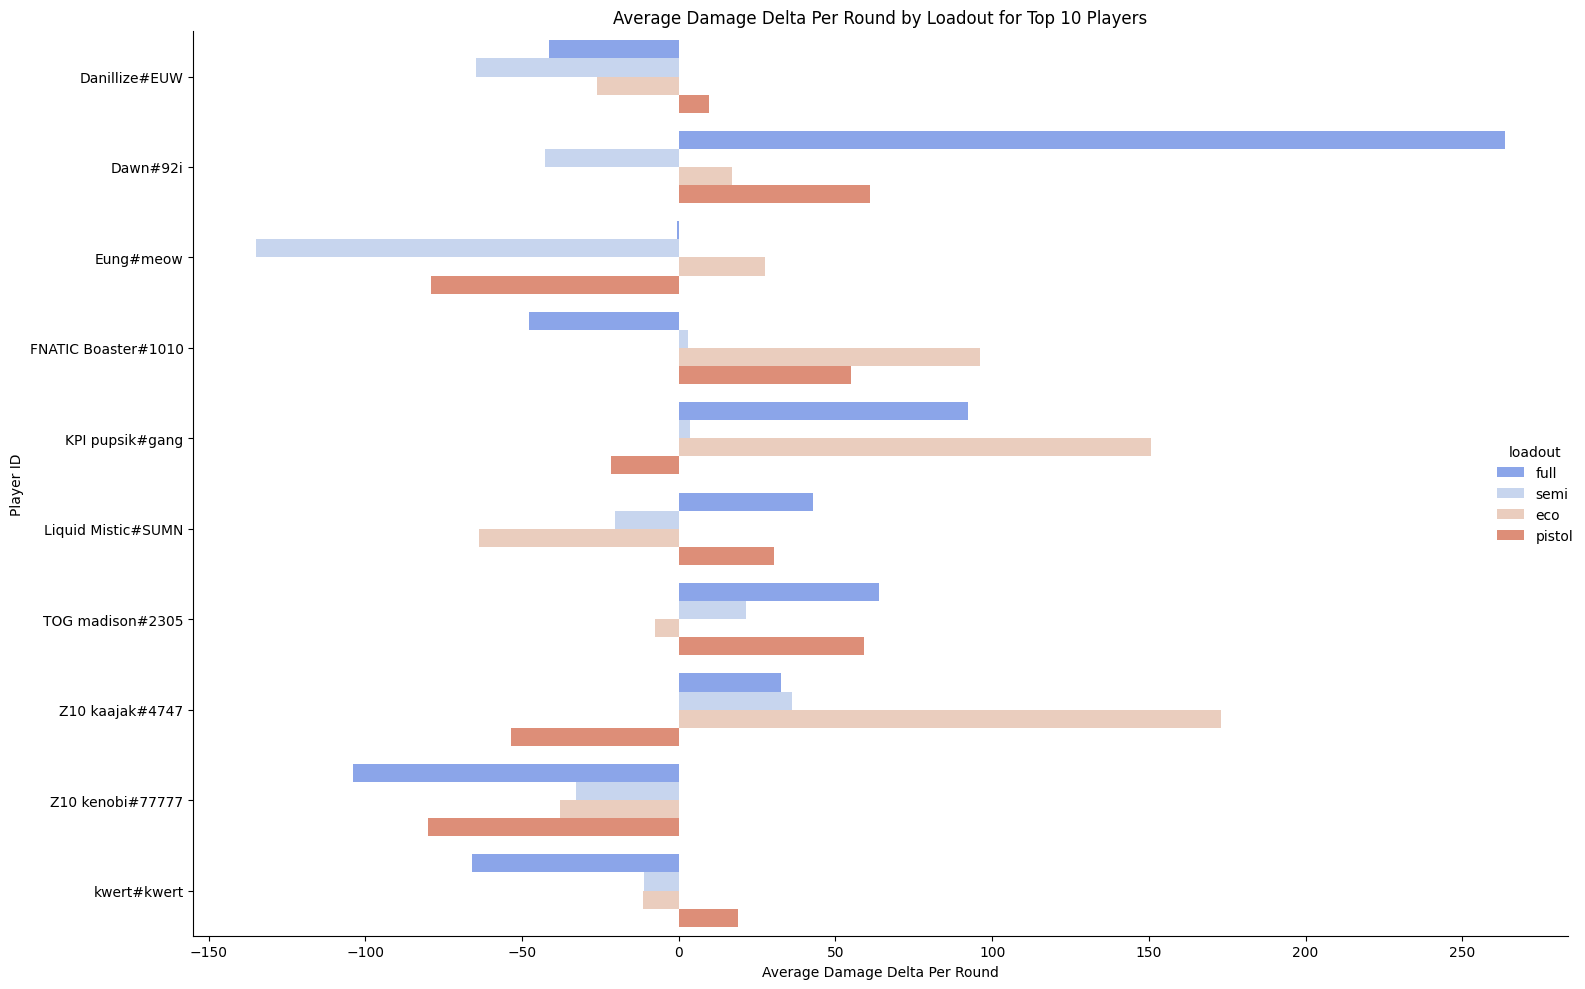

In [695]:
# Average Damage Delta Per Round by Loadout for Top 10 Players
sns.catplot(x="damageDeltaPerRound", y="platformUserIdentifier", hue="loadout", data=top_players_damage_metrics, kind="bar", height=10, aspect=1.5, palette="coolwarm")
plt.title('Average Damage Delta Per Round by Loadout for Top 10 Players')
plt.xlabel('Average Damage Delta Per Round')
plt.ylabel('Player ID')
plt.tight_layout()
plt.show()

We've broken down the Damage Metrics by individual players, focusing on the top 10 players based on their average damagePerRound. The bar charts represent:

- **Average Damage Per Round by Loadout for Top 10 Players:** This chart shows how much damage each of the top 10 players inflicts per round for various loadout types. It's a good indicator of a player's offensive impact on the game.

- **Average Damage Delta Per Round by Loadout for Top 10 Players:** This chart shows the difference between damage inflicted and damage received for the top 10 players across each loadout. A positive number means the player deals more damage than they receive, indicating a strong net impact.

## Round Win Predictions

### Data Preprocessing

Replace missing values

In [696]:
player_round_df.isna().sum()

round                     0
platformUserIdentifier    0
teamId                    0
teamSide                  0
agentKey                  0
hasWon                    0
score                     0
kills                     0
deaths                    0
kdRatio                   0
assists                   0
damage                    0
loadoutValue              0
remainingCredits          0
spentCredits              0
agentName                 0
kdRatio_norm              0
assists_norm              0
damage_norm               0
performance               0
economic_efficiency       1
dtype: int64

In [697]:
# Fill the missing economic_efficiency values wiht 0.  They were only NAN to avoid the case where we were dividing by 0
player_round_df['economic_efficiency'] = player_round_df['economic_efficiency'].fillna(0)

In [698]:
# Sanity check
player_round_df.isna().sum()

round                     0
platformUserIdentifier    0
teamId                    0
teamSide                  0
agentKey                  0
hasWon                    0
score                     0
kills                     0
deaths                    0
kdRatio                   0
assists                   0
damage                    0
loadoutValue              0
remainingCredits          0
spentCredits              0
agentName                 0
kdRatio_norm              0
assists_norm              0
damage_norm               0
performance               0
economic_efficiency       0
dtype: int64

Encode categorical variables

In [699]:
# Encode categorical variables
label_encoder = LabelEncoder()
player_round_df['teamId_encoded'] = label_encoder.fit_transform(player_round_df['teamId'])
player_round_df['teamSide_encoded'] = label_encoder.fit_transform(player_round_df['teamSide'])
player_round_df['agentName_encoded'] = label_encoder.fit_transform(player_round_df['agentName'])
player_round_df['platformUserIdentifier_encoded'] = label_encoder.fit_transform(player_round_df['platformUserIdentifier'])

### Feature Selection

Lets start with all features and see how that performs.

In [700]:
features = ['round', 'platformUserIdentifier_encoded', 'teamId_encoded', 'teamSide_encoded', 'agentName_encoded', 'score', 'kills', 'deaths', 'kdRatio', 'assists', 'damage', 'loadoutValue', 'remainingCredits', 'spentCredits', 'performance', 'economic_efficiency']
target = 'hasWon'

### Model Training

In [701]:
# Splitting the dataset into training and testing sets
X = player_round_df[features]
y = player_round_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# standardize features
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

We've successfully prepared the dataset for machine learning. Here's a quick recap of the steps:

1. Encode Categorical Variables: We encoded the teamId, teamSide, platformUserIdentifier and agentName columns into numerical values suitable for machine learning algorithms.
2. Feature Selection: We selected a set of features that include round information, player statistics, and economic variables.
3. Data Splitting: We've split the data into training and test sets, with 80% for training and 20% for testing.

Next, we'll move on to Model Training. We'll use a Random Forest Classifier for this initial exercise. The choice is motivated by the model's robustness and ability to handle both categorical and numerical features well.

In [702]:
# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_std, y_train)

RandomForestClassifier(random_state=0)

### Evaluation

In [703]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_std)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.88      0.92        25
        True       0.82      0.93      0.87        15

    accuracy                           0.90        40
   macro avg       0.89      0.91      0.90        40
weighted avg       0.91      0.90      0.90        40



We've successfully trained a Random Forest Classifier and evaluated its performance on the test set. Here are some key metrics:

- Accuracy: The model achieved an accuracy of approximately 90%, which means it correctly predicted the outcome of about 90% of the rounds in the test set.
- Classification Report:Precision, recall, and F1-score are also reasonably good, indicating that the model performs well for both classes (win and loss).

Lets try and see if we can do better.

### Identify the most important features

Use a Random Forest to identify the most important features.

In [704]:
# Train-test split the data
train_df, test_df = train_test_split(player_round_df, test_size=0.3, random_state=0)

# Create the training set
X_train = train_df[features]
y_train = train_df[target]

# Create the testing set
X_test = test_df[features]
y_test = test_df[target]

# Standardize features
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Train a Random Forest model
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_std, y_train);

Display the proportional importance of each feature

In [705]:
# feature_importances_ will always sum to 1
rf.feature_importances_

array([0.12546639, 0.03895581, 0.04240723, 0.16244184, 0.02965713,
       0.04833908, 0.01013297, 0.16641767, 0.00856367, 0.01397795,
       0.03788023, 0.05896944, 0.06020956, 0.05136804, 0.08467042,
       0.06054256])

Get the indices of the most important features sorted by importance

In [706]:
# Sort the feature importances by their index position, then reverse the order
# so that they are displayed from largest (most important) to smallest.

index_of_best_features_in_order = rf.feature_importances_.argsort()[::-1]
index_of_best_features_in_order

array([ 7,  3,  0, 14, 15, 12, 11, 13,  5,  2,  1, 10,  4,  9,  6,  8])

Order the features by importance using the sorted indices above

In [707]:
X_train.columns

Index(['round', 'platformUserIdentifier_encoded', 'teamId_encoded',
       'teamSide_encoded', 'agentName_encoded', 'score', 'kills', 'deaths',
       'kdRatio', 'assists', 'damage', 'loadoutValue', 'remainingCredits',
       'spentCredits', 'performance', 'economic_efficiency'],
      dtype='object')

In [708]:
# Display the best features in order
features = np.array(X_train.columns)

list_of_best_features_in_order = features[index_of_best_features_in_order]

print("The best features in order:")
print(list_of_best_features_in_order)

The best features in order:
['deaths' 'teamSide_encoded' 'round' 'performance' 'economic_efficiency'
 'remainingCredits' 'loadoutValue' 'spentCredits' 'score' 'teamId_encoded'
 'platformUserIdentifier_encoded' 'damage' 'agentName_encoded' 'assists'
 'kills' 'kdRatio']


Sort the importance values, largest to smallest

In [709]:
importances_ordered = sorted(rf.feature_importances_, reverse=True)
importances_ordered

[0.16641766992449714,
 0.16244184331883607,
 0.12546638807178534,
 0.08467041879825361,
 0.060542558451795535,
 0.06020955631741856,
 0.05896944424973018,
 0.051368035003490194,
 0.0483390796712862,
 0.042407234225343544,
 0.038955810590319336,
 0.03788023398024381,
 0.029657134681257625,
 0.013977946571671184,
 0.010132974170167083,
 0.008563671973904506]

In [710]:
most_important_features_df = pd.DataFrame(data=[importances_ordered],
                                          columns=list_of_best_features_in_order,
                                         index=["importance"])
most_important_features_df

,deaths,teamSide_encoded,round,performance,economic_efficiency,remainingCredits,loadoutValue,spentCredits,score,teamId_encoded,platformUserIdentifier_encoded,damage,agentName_encoded,assists,kills,kdRatio
importance,0.166418,0.162442,0.125466,0.08467,0.060543,0.06021,0.058969,0.051368,0.048339,0.042407,0.038956,0.03788,0.029657,0.013978,0.010133,0.008564


Grab the features with an importance of 3% or higher

In [711]:
most_important_features = []
for col in most_important_features_df.columns:
    if (most_important_features_df.loc['importance'][col]) >= 0.03:
      most_important_features.append(col)

most_important_features

['deaths',
 'teamSide_encoded',
 'round',
 'performance',
 'economic_efficiency',
 'remainingCredits',
 'loadoutValue',
 'spentCredits',
 'score',
 'teamId_encoded',
 'platformUserIdentifier_encoded',
 'damage']

Try again but only using the best features

In [712]:
features = most_important_features;

# Splitting the dataset into training and testing sets
X = player_round_df[features]
y = player_round_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize features
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_std, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_std)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98        25
        True       0.94      1.00      0.97        15

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



By using the "best features" we even further increased our model's performance:
- Accuracy: The model achieved an accuracy of approximately 97%, which is a significant increase over the previous 90%.
- Classification Report: We also saw a significant uptick in both F1 scores.

While the model is relatively simple and the dataset is not very large, these are promising results for a first attempt. The model could serve as a baseline for more complex models and feature engineering in the future.
